<a href="https://colab.research.google.com/github/deltorobarba/machinelearning/blob/master/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Time Series Forecasting**

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
print('Tensorflow version %s' % tf.__version__)

# **Exploration**

**Data Import and Preprocessing**

In [2]:
url = 'https://raw.githubusercontent.com/deltorobarba/machinelearning/master/google.csv'
data = pd.read_csv(url)
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-02-01,266.301849,266.904572,264.159851,265.514771,265.514771,4518400
1,2010-02-02,266.481171,266.481171,262.819885,264.568329,264.568329,8223000
2,2010-02-03,263.347900,270.037842,263.128723,269.400208,269.400208,6020500
3,2010-02-04,267.497345,267.995483,261.798706,262.406433,262.406433,6780600
4,2010-02-05,263.213409,265.753876,260.254517,264.653015,264.653015,6335600


In [0]:
series = data[['Date', 'Close']].rename(columns={"Date": "date", "Close": "values"}).set_index('date')
series.index = pd.to_datetime(series.index, utc=False)
series.head()

,values
date,
2010-02-01,265.514771
2010-02-02,264.568329
2010-02-03,269.400208
2010-02-04,262.406433
2010-02-05,264.653015


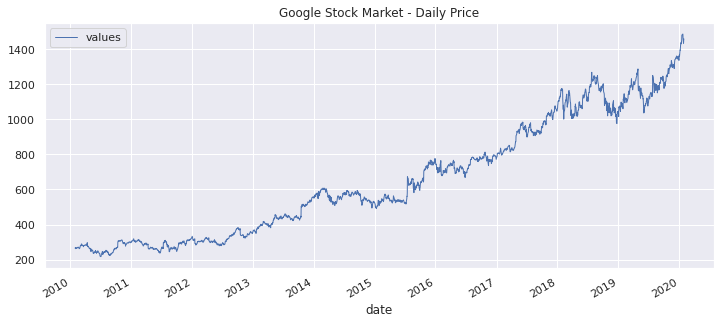

In [0]:
sns.set(rc={'figure.figsize':(12, 5), "lines.linewidth": 1.0})
series.plot(title='Google Stock Market - Daily Price')

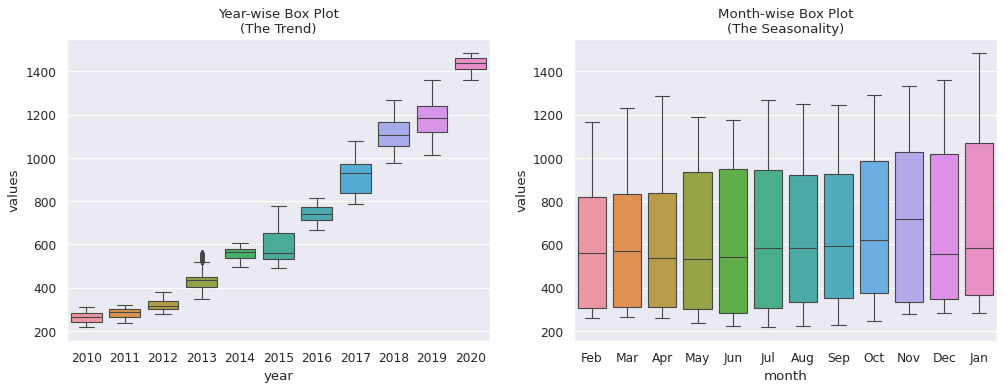

In [0]:
# Trend and Seasonality Test
seasonal_plots = series.copy()
seasonal_plots.reset_index(inplace=True)

# Prepare data
seasonal_plots['year'] = [d.year for d in seasonal_plots.date]
seasonal_plots['month'] = [d.strftime('%b') for d in seasonal_plots.date]
years = seasonal_plots['year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(15,5), dpi= 80)
sns.boxplot(x='year', y='values', data=seasonal_plots, ax=axes[0])
sns.boxplot(x='month', y='values', data=seasonal_plots.loc[~seasonal_plots.year.isin([1991, 2008]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=12); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=12)
plt.show()

# **Preparation**

In [0]:
# Set seed for reproducibility
tf.random.set_seed(7)

**Data Normalization**

Normalization (feature rescaling): data values between 0 and 1. Normalization is used when distribution of data is unknown or not Gaussian, and the algorithm does not make assumptions about data distribution (k-nearest neighbors or neural nets). Different formula. One way:

$x_{n e w}=\frac{x-x_{m i n}}{x_{m a x}-x_{m i n}}$

Standardization (z-score or t-score): transforms data to have a mean of zero and a standard deviation of 1. z-score is number of standard deviations from mean (e.g. score of 2 is 2 std above mean). Standardization assumes Gaussian distribution (not strictly true, but more effective). and the algorithm assumes Gaussian distribution (linear regression, logistic regression, linear discriminant analysis).

$z_{i}=\frac{x_{i}-\bar{x}}{s}$

In [0]:
# LSTMs are sensitive to scale of input data
from sklearn.preprocessing import MinMaxScaler
dataset = series.copy()
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.03804384],
       [0.03729827],
       [0.04110461],
       ...,
       [0.95844589],
       [0.97314544],
       [0.97792707]])

**Train & Test Split**

In [0]:
# in % of complete dataset
split = 0.8
train_size = int(len(dataset) * split)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
train [0:5] # Show first few values in train data array

array([[0.03804384],
       [0.03729827],
       [0.04110461],
       [0.03559523],
       [0.03736499]])

**Create Sliding Windows (X input & Y output)**

* Window is the number of previous time steps to use as input variables to predict the next time period
* Given the current time (t) we want to predict the value at the next time in the sequence (t+1), 
* Phrased as a regression: input variables are t-2, t-1, t and the output variable is t+1

In [0]:
window = 3 # Use (t), (t-1) and (t-2) as input variables X
features = 1 # Use only one time series (Google stock data)

# Convert an array of values into a dataset matrix
def create_dataset(dataset, window=window):
	dataX, dataY = [], []
	for i in range(len(dataset)-window-1):
		a = dataset[i:(i+window), 0]
		dataX.append(a)
		dataY.append(dataset[i + window, 0])
	return np.array(dataX), np.array(dataY)

# X is input data = value (at t, and t-1, t-2, depending on window size)
# Y is target data = value at t+1
# Each is additionally divided into train and test set

# Reshape into X=t and Y=t+1 and get as arrays
trainX, trainY = create_dataset(train, window)
testX, testY = create_dataset(test, window)

In [0]:
# X input has 3 (= window size) values at each step
trainX

array([[0.03804384, 0.03729827, 0.04110461],
       [0.03729827, 0.04110461, 0.03559523],
       [0.04110461, 0.03559523, 0.03736499],
       ...,
       [0.71888154, 0.72496299, 0.73937896],
       [0.72496299, 0.73937896, 0.75053351],
       [0.73937896, 0.75053351, 0.74601968]])

In [0]:
# Y output has here only one value (t+1) at each step
trainY

array([0.03559523, 0.03736499, 0.03822044, ..., 0.75053351, 0.74601968,
       0.75084863])

Notice how the shape differs: there are 3 values at each step for the input (since we look back 3 steps), but only one value at eahc step for the output, since do not have a multistep forecasting here.

**Reshape Data for LSTM**

* Data is in shape **[samples, features]**. LSTM expects **[samples, time steps, features]**
* Reminder 2D array: shape (n,m), n [0] = rows (time steps), m [1] = column(s)
* Shape: First Block: t, t+1, t+2. Second: t+1, t+2, t+3. Third: t+2, t+3, t+4.
* Approach 1: Use past observations as separate input features =(trainX.shape[0], features, trainX.shape[1])
* Approach 2: Use past observations as time steps of the one input feature **(we do here!)**

In [0]:
trainX = tf.reshape(trainX, (trainX.shape[0], trainX.shape[1], features))
testX = tf.reshape(testX, (testX.shape[0], testX.shape[1], features))
trainX

<tf.Tensor: shape=(2008, 3, 1), dtype=float64, numpy=
array([[[0.03804384],
        [0.03729827],
        [0.04110461]],

       [[0.03729827],
        [0.04110461],
        [0.03559523]],

       [[0.04110461],
        [0.03559523],
        [0.03736499]],

       ...,

       [[0.71888154],
        [0.72496299],
        [0.73937896]],

       [[0.72496299],
        [0.73937896],
        [0.75053351]],

       [[0.73937896],
        [0.75053351],
        [0.74601968]]])>

# **Model**

**Set Hyperparameter**

In [0]:
optimizer = tf.keras.optimizers.Adam(0.0001)
loss = 'mean_squared_error'
activation = 'tanh'
recurrent_activation= 'sigmoid'
epochs = 8
repeat = 2
batch_size = 4
verbose = 1
units = 16
dropout = 0.02
recurrent_dropout = 0.02

**Create Model** 

In [0]:
# Deep Stacked LSTM with Memory Between Batches

from tensorflow.keras import layers

model = tf.keras.Sequential()
model.add(layers.LSTM(units, 
               batch_input_shape=(batch_size, window, 1), 
               activation=activation,
               recurrent_activation=recurrent_activation,
               dropout=dropout,
               recurrent_dropout=recurrent_dropout,
               unroll=True,
               stateful=True, 
               return_sequences=True))
model.add(layers.LSTM(units, 
               batch_input_shape=(batch_size, window, 1), 
               activation=activation,
               recurrent_activation=recurrent_activation,
               dropout=dropout,
               recurrent_dropout=recurrent_dropout,
               unroll=True,
               stateful=True, 
               return_sequences=True))
model.add(layers.LSTM(units, 
               batch_input_shape=(batch_size, window, 1),
               activation=activation,
               recurrent_activation=recurrent_activation,
               dropout=dropout,
               recurrent_dropout=recurrent_dropout,
               unroll=True,
               stateful=True))
model.add(layers.Dense(1))

**Display Model Topology**

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (4, 3, 16)                1152      
_________________________________________________________________
lstm_1 (LSTM)                (4, 3, 16)                2112      
_________________________________________________________________
lstm_2 (LSTM)                (4, 16)                   2112      
_________________________________________________________________
dense (Dense)                (4, 1)                    17        
Total params: 5,393
Trainable params: 5,393
Non-trainable params: 0
_________________________________________________________________


**Compile Model**

In [0]:
model.compile(optimizer=optimizer, 
              loss=loss, 
              metrics=['accuracy'])

**Prepare Visualization**

In [0]:
# Plot Losses Keras TF (simple)
!pip install livelossplot --quiet
from livelossplot import PlotLossesKerasTF

#  TensorBoard (advanced)
%load_ext tensorboard
!rm -rf ./logs/
logdir = "logs/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

# Select visualization method
callbacks = [PlotLossesKerasTF()] # [tensorboard_callback]

**Train Model**

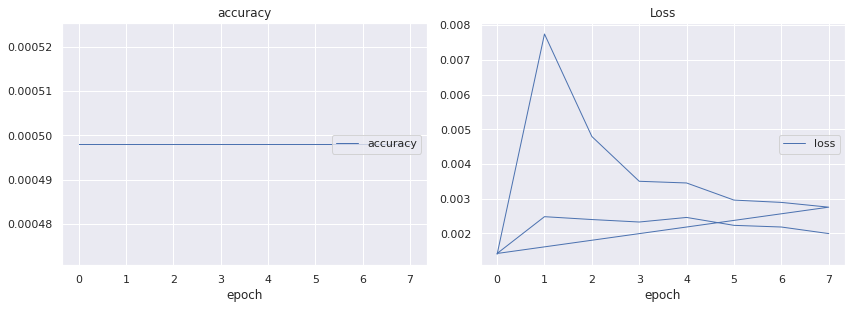

accuracy
	accuracy         	 (min:    0.000, max:    0.000, cur:    0.000)
Loss
	loss             	 (min:    0.001, max:    0.008, cur:    0.002)
502/502 [==============================] - 2s 4ms/step - loss: 0.0020 - accuracy: 4.9801e-04


In [0]:
for i in range(repeat):
	model.fit(trainX, trainY, 
	          epochs=epochs, 
					  batch_size=batch_size, 
						verbose=verbose, 
						shuffle=False, 
            callbacks=callbacks)
	model.reset_states()

**Results in TensorBoard**

In [0]:
# %tensorboard --logdir logs/

**Simpler LSTM model (alternative)**

In [0]:
# Second (simpler) Model
# Use past observations as input features (=3) and only one time step

# Reshape Data Format for LSTM
# trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
# testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Model create and train
# model = Sequential()
# model.add(LSTM(4, input_shape=(1, window)))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')
# model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2)

# **Predictions**

**Make Predictions**

In [0]:
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)

**Invert predictions**

In [0]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

**Calculate RMSE**

In [0]:
import math
from sklearn.metrics import mean_squared_error

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 103.84 RMSE
Test Score: 98.72 RMSE


**Plot results**

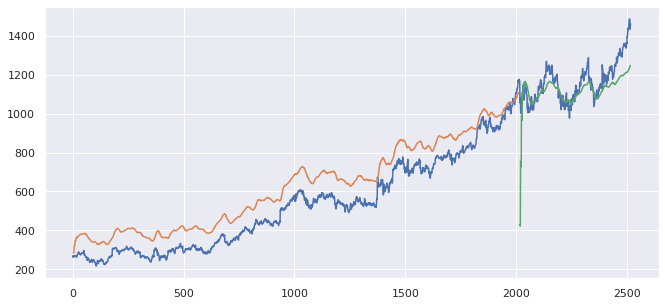

In [0]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[window:len(trainPredict)+window, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(window*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
sns.set(rc={'figure.figsize':(11, 5)})
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# **Residuals**

Residuals are useful in checking whether a model has adequately captured the information in the data. Residuals analysis is very important for reviewing and finetuning classic time series models, but becomes increasingly relevant also for more advanced machine learning models. 

Ideally, the residuals are only whote noise processes with no more information left. In a good model the residuals are stationary, which can be broken down into following requirements:

**Essential (necessary) properties:**

1. The residuals are uncorrelated. If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts.
2. The residuals have zero mean. If the residuals have a mean other than zero, then the forecasts are biased.

**Additional useful (but not necessary) properties:**

3. The residuals have constant variance.
4. The residuals are normally distributed.


**Get residuals**

In [0]:
residuals = (testY[0] - testPredict[:,0])
res = pd.DataFrame(data=residuals, columns=['residuals'])
res.head()

,residuals
0,739.075195
1,683.967559
2,628.940918
3,658.629731
4,294.690796


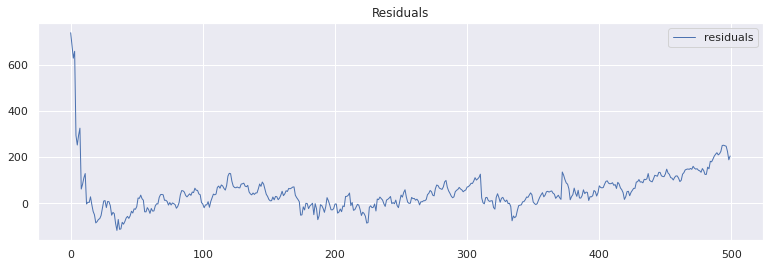

In [0]:
# Visualize Series
sns.set(rc={'figure.figsize':(13, 4), "lines.linewidth": 1.0})
res.plot(title='Residuals')

Most of thre time it looks mean-reverting, which is desirable. Just at the end it seems to have a trend upwards, which means there is still information left in the residuals. 

In [0]:
res.describe()

,residuals
count,500.000000
mean,46.905896
std,86.954034
min,-117.709656
25%,-1.240539
50%,34.558350
75%,75.760712
max,739.075195


**Are residuals autocorrelated?**

In [0]:
# Durban-Watson Statistic. Value 2: no serial correlation. 0: positive correlation. 4: negative correlation
import statsmodels.api as sm
import statsmodels.tsa.stattools
statsmodels.stats.stattools.durbin_watson(res.residuals, axis=0)

Positive autocorrelation still existent.

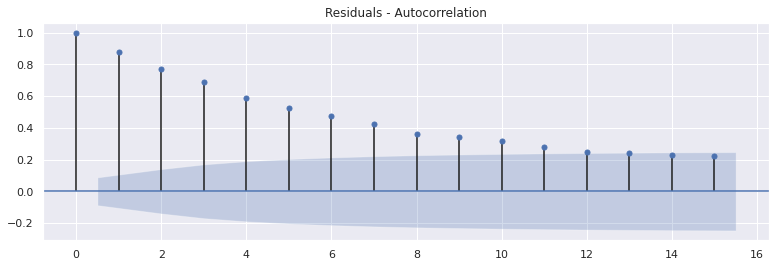

In [0]:
from statsmodels.graphics.tsaplots import plot_acf
sns.set(rc={'figure.figsize':(13, 4)})
plot_acf(res.residuals.squeeze(), lags=15)
plt.title('Residuals - Autocorrelation')
plt.show()

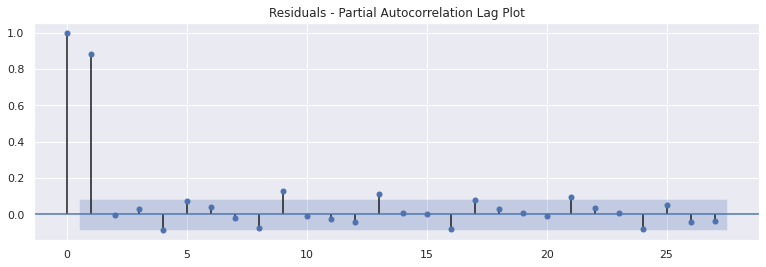

In [0]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(res.residuals)
plt.title('Residuals - Partial Autocorrelation Lag Plot')
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


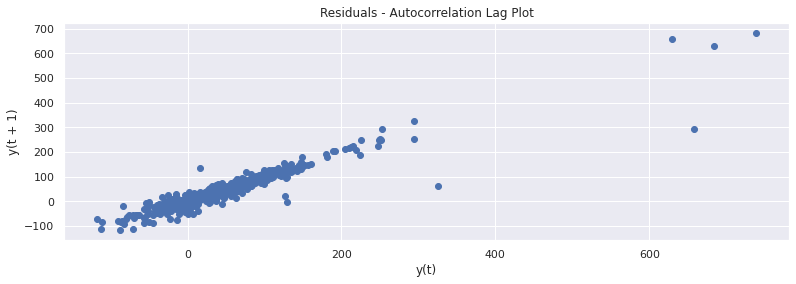

In [0]:
from pandas.plotting import lag_plot
lag_plot(res.residuals)
plt.title('Residuals - Autocorrelation Lag Plot')
plt.show()

Yes, there is a strong autocorrelation still at lag 1. 

**Is the mean zero?**

In [0]:
# Mean (must be nearly zero)
res.residuals.mean()

46.90589649507036

Text(0.5, 1.0, 'Residuals - Boxplot')

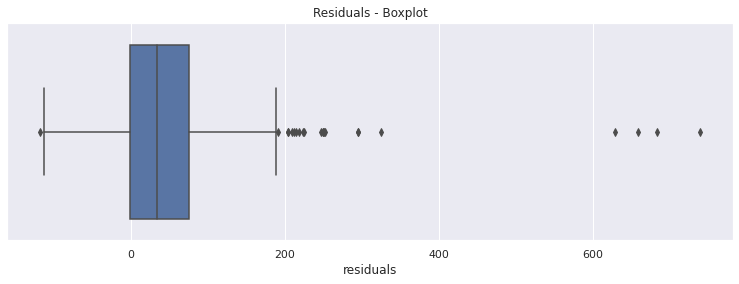

In [0]:
sns.boxplot(res.residuals).set_title('Residuals - Boxplot')

No, residuals don't have the mean at zero.

**Are residuals normally distributed?**

In [0]:
# Distribution (H0: sample normal distributed)
import scipy
from scipy import stats
stats.normaltest(res.residuals)

NormaltestResult(statistic=408.327103969085, pvalue=2.1522661104514452e-89)

In [0]:
k2, p = stats.normaltest(res.residuals)
print("p = {:g}".format(p))

p = 2.15227e-89


In [0]:
alpha = 1e-3
if (p < alpha):
  print("The null hypothesis that x comes from a normal distribution can be rejected")
else:
  print("The null hypothesis that x comes from a normal distribution cannot be rejected")

The null hypothesis that x comes from a normal distribution can be rejected


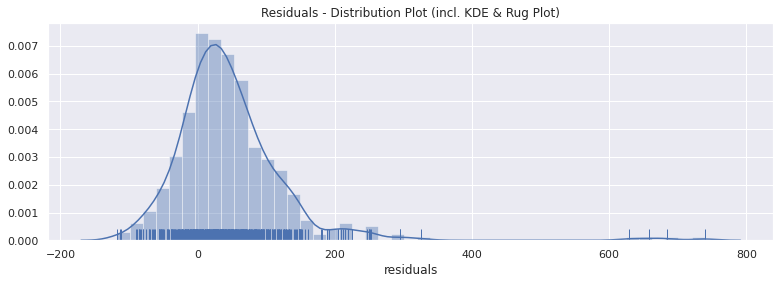

In [0]:
sns.set(rc={'figure.figsize':(13, 4)})
sns.distplot((res.residuals), hist=True, rug=True).set_title('Residuals - Distribution Plot (incl. KDE & Rug Plot)')
plt.show()

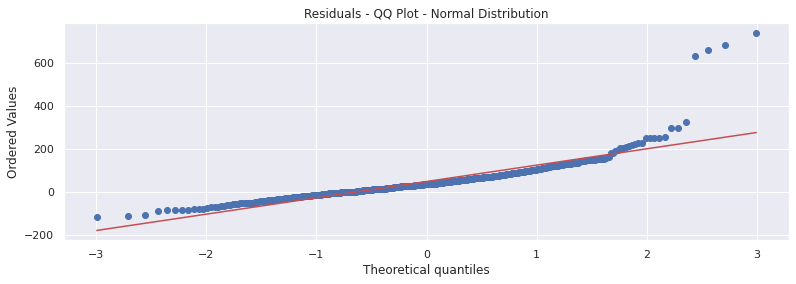

In [0]:
import scipy
from scipy import stats
stats.probplot(res.residuals, dist="norm", plot=plt)
plt.title('Residuals - QQ Plot - Normal Distribution')
plt.show()

No, residuals are not normally distributed. Though it seems very well normally distributed without the positive outliers.

**Is the variance constant? (Stationarity)**

In [0]:
# Augmented Dickey Fuller. H0: There is a unit root for the series (non stationary)
from statsmodels.tsa.stattools import adfuller
adfuller(res.residuals, maxlag=None, regression='ctt', autolag='AIC', store=False, regresults=False)

(-9.596235093485872,
 4.2118758155258344e-14,
 0,
 499,
 {'1%': -4.394499384993899,
  '10%': -3.56061563621329,
  '5%': -3.844276182553822},
 4166.41213994771)

P-value is < 0.05. reject H0. Series seems mostly stationary.